# Testing Bin Selection Idea

In [1]:
import h5py
import import_ipynb
import os
os.environ['SPS_HOME'] = '/home/benjamin.hanson/UF REU/SED-Fitting/UF-REU-PROJECT'
import fsps
%matplotlib inline
import math
import matplotlib.pyplot as plt
import csv
import numpy as np
import scipy.odr.odrpack as odrpack
import math
import scipy as scipy
from scipy import optimize
from scipy import interp
from scipy import integrate
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm
import sys
import csv
from importlib import reload
from rbvfit import model as m
reload(m)

import emcee
import corner
import scipy.optimize as op

width = 30

import time
from multiprocessing import cpu_count
from multiprocessing import Pool
import random
from IPython.display import clear_output

In [2]:
def creating_array(metallicity_array, age_array):
    
    mass_array = []
    
    print("Deleting previous iterations of spectrums...")
    # Deleting previous iteration of spectrum
    if 'sp' in locals():
        del sp
    
    rows = len(metallicity_array)
    columns = len(age_array)
    with open('stellar_bank_{}x{}.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        print("Creating new array...")
        # Creating Array
        
        sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol = 0, dust_type=2, dust2=0.0)
       
        for i in range(len(metallicity_array)):
            
            metallicity = metallicity_array[i]
            sp.params['logzsol'] = metallicity
                        
            for j in range(len(age_array)):
                
                age = age_array[j]
                wave, spec = sp.get_spectrum(tage = age)
                mass_array.append(str(sp.stellar_mass))
                spec = list(spec)
                spec = list(map(str, spec))
                write.writerow(spec)   
    
    print("Spectrum array complete. Writing Mass Array.")
    with open('stellar_bank_{}x{}_mass.csv'.format(str(int(rows)), str(int(columns))), 'w') as f:
        write = csv.writer(f)
        
        for i in range(len(mass_array)):
            
            value = mass_array[i]
            write.writerow([value])
            
    print("Mass Array Complete")    
        
def reading_csv(file_name, rows, columns):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []

    r = rows
    c = columns
    iterator = 0

    for i in range(r):
        for j in range(c):
            new_array[iterator] = list(map(float, new_array[iterator]))
            uf_sub_array.append(new_array[iterator])
            iterator += 1
        uf_array.append(uf_sub_array)
        uf_sub_array = []
    
    return uf_array

def reading_csv_obs(file_name, rows, columns, fields, layers):
    
    print("Reading array...")
    new_array = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            new_array.append(row)
    
    print("Unflattening array...")
    # Unflattening Array
    uf_array = []
    uf_sub_array = []
    uf_sub_sub_array = []
    uf_sub_sub_sub_array = []

    r = rows
    c = columns
    f = fields
    l = layers
    iterator = 0

    for i in range(r):
        for j in range(c):
            for k in range(f):
                for m in range(l):
                    new_array[iterator] = list(map(float, new_array[iterator]))
                    uf_sub_sub_sub_array.append(new_array[iterator])
                    iterator += 1
                uf_sub_sub_array.append(uf_sub_sub_sub_array)
                uf_sub_sub_sub_array = []
            uf_sub_array.append(uf_sub_sub_array)
            uf_sub_sub_array = []
        uf_array.append(uf_sub_array)
        uf_sub_array = []        
    
    return uf_array

def make_spectrum(age, metallicity):
    sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1, sfh=0, logzsol= metallicity, dust_type=2, dust2=0.0)
    wave, spec = sp.get_spectrum(tage = age)
    del sp
    
    return wave, spec
    
def chi_sq_func(obs_Spec, exp_Spec):
    chiSq = 0
    for i in range(len(obs_Spec)):
        chiSq += ((obs_Spec[i] - exp_Spec[i])**2)/exp_Spec[i]
        
    return chiSq

def plt_spectra(wave, spec, theta):
    plt.loglog(wave, spec, label = "Params: logZ = {}, Age (Gyr) = {}".format(theta[0], theta[1]))

def model_guess(beta,input_wave):
    
    spec = interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec

def model_guess_obs(beta,input_wave):
    
    spec = obs_interpolating_spec(beta)[0]
    
    if (len(spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, spec)
        spec = trunc_spec    

    return spec
    
def make_corner_plots(sampler):
          
    samples=sampler.chain[:, 100:, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    figure=corner.corner(samples, labels=text_label, truths=st)
    theta_prime=st

    value1 =np.percentile(samples,32,axis=0)
    value2 = np.percentile(samples,68,axis=0)    
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1[i], color="aqua")
        ax.axvline(value2[i], color="aqua")

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi],color="aqua")
            ax.axvline(value2[xi],color="aqua")
            #ax.axhline(value1[yi], color="g")
            #ax.axhline(value2[yi], color="r")
            #ax.plot(value1[xi], value1[yi], "sg")
            #ax.plot(value2[xi], value2[yi], "sr")

def build_weight_array(weight_array, row_array, column_array, weight_added_array):
    for i in range(len(row_array)):
        weight_array[row_array[i]][column_array[i]] += weight_added_array[i]
    return weight_array    

def generate_random_weight_array(lb, ub, metallicity_array, age_array):
    
    weight_array= []
    
    s2 = np.random.normal(1.0, 0.01, 10000)
    count2, bins2, ignored2 = plt.hist(s2, 3, stacked = True, density = True)

    count2 *= 1 / count2[1]
    
    for i in range(len(metallicity_array)):
        bounds = np.array([lb, ub])
        mean = np.mean(bounds)
        std = mean * 0.1
        s = np.random.normal(mean, std, 10000)
        count, bins, ignored = plt.hist(s, 10, stacked = True, density = True)
        
        correction = 1 / sum(count)
        count *= correction 
        count *= count2[i] * ub
    
        count[count > ub] = ub
        count[count < lb] = lb
        weight_array.append(list(count))
    
    return weight_array
                      
def galactic_spec(weight_array, input_wave, bin_array):
    
    weight_array = weight_array.flatten()

    total_spec = np.zeros(5994)

    for i in range(len(weight_array)):
        met = np.array([bin_array[i][0]])
        age = np.array([bin_array[i][1]])

        theta = np.concatenate((met, age))
        spec = interpolating_spec(theta)[0]
        total_spec += (spec * weight_array[i])
    
    return total_spec

def galactic_model_guess(weight_array, input_wave, bin_array):
    
    total_spec = galactic_spec(weight_array, input_wave, bin_array)
    
    if (len(total_spec) != len(input_wave)):
        trunc_spec = np.interp(input_wave, wave, total_spec)
        total_spec = trunc_spec        
    
    return total_spec

def print_and_plot_results(sampler, wave, spec, title, galaxy, model, bin_array):
    
    samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
    st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
    theta_prime=st[:]
    
    print("Derived values are (weight array): \n {}".format(theta_prime))   
    best_fit = model(theta_prime, wave, bin_array)

    fig= plt.figure(figsize=(12,8))
    
    plt.loglog(wave, spec, ls = 'dotted', label= galaxy) 
    plt.title(title, fontsize = 20)
    plt.ylabel('Intensity (Solar luminosity/Hz)', fontsize = 18) # Labeling the x-axis
    plt.xlabel('Wavelength (Angstroms)', fontsize = 18) # Labeling the y-axis
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})
    
    return best_fit, theta_prime

def initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, snorm, enorm, input_wave, model, bin_array):
    
    likelihood = []
    fits = []
    weight_arrays = []
    total_steps = 0
    curr_likelihood = 0
    convergence_status = False
    
    if (convergence_check == False):
        
        while (total_steps < break_steps):
            for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps, skip_initial_state_check = True)):
                n = int((width+1) * float(i) / no_of_steps)
                sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
            sys.stdout.write("\n")
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm, bin_array)
            likelihood.append(curr_likelihood)
            sampler_ = np.array( sampler.chain )
            sub_array = []
            position_array = []
            chain_length = len(sampler_[0])
            for i in range(len(sampler_)):
                for j in range(len(sampler_[0][0])):           
                    sub_array.append(sampler_[i][chain_length-1][j])
                position_array.append(sub_array)
                sub_array = []
    
            pos = np.array(position_array)
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
    else:
        while(convergence_status == False):
            for i, result in enumerate(sampler.sample(pos, iterations=no_of_steps, skip_initial_state_check = True)):
                n = int((width+1) * float(i) / no_of_steps)
                sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
            sys.stdout.write("\n")
            clear_output(wait=True)
            samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain
            st=np.median(samples,axis=0)#np.median(sampler.flatchain, axis=0)
            curr_likelihood = lnlike(st, model, input_wave, snorm, enorm, bin_array)
            likelihood.append(curr_likelihood)
            sampler_ = np.array( sampler.chain )
            convergence_status, pos = check_convergence(sampler_, convergence_accuracy)
            total_steps += no_of_steps
            print("Steps Taken: ", total_steps, "Likelihood: ", curr_likelihood)
            if (total_steps >= break_steps):
                convergence_status = True
                print("Convergence not found before break.")

        print("Total steps to converge: ", total_steps)

    return sampler, likelihood

def check_convergence(sampler_, convergence_accuracy):
    
    # Converting Sampler Array to something more useable
    chain = []
    walkers = []
    parameters = []
    
    chain_length = len(sampler_[0])

    for i in range(len(sampler_[0][0])):
        for j in range(len(sampler_)):
            for k in range(len(sampler_[0])):
                chain.append(sampler_[j][k][i])
            walkers.append(chain)
            chain = []
        parameters.append(walkers)
        walkers = []  
            
    # Getting Last Position to save 
    sub_array = []
    position_array = []

    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []
    
    position = np.array(position_array)
    
    # Checking Convergence of Walkers
    
    walkers = len(parameters[0])
    chain_length = len(parameters[0][0])
    convergence_status = True
    avg_serr = 0
    
    for i in range(len(parameters)):
        for j in range(len(parameters[0])):
            serr = np.std(parameters[i][j])/(chain_length)
            avg_serr += serr
        avg_serr /= walkers
        
        if (avg_serr <= convergence_accuracy):
            continue
        else:
            print("Parameter {} has not converged. Avg. SE was {:.3e}.".format(i, avg_serr))
            convergence_status = False
            break
            
    return convergence_status, position


######## Computing Likelihoods######
def lnprior(theta, lb, ub):
    for index in range(0, len(lb)):
        if (lb[index] > theta[index]) or (ub[index] < theta[index]):
            return -np.inf
    return 0.0

def lnlike(theta, model, x, y, yerr, bin_array):
    model_y = model(theta, x, bin_array)
    model_y = np.log10(model_y)
    y = np.log10(y)
    yerr = y * 0.1
    inv_sigma2 = 1.0/(yerr**2)
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  - np.log10(inv_sigma2)
    return -0.5 * (np.sum( all_c2_values  )) 

def lnprob(theta, lb, ub, model, x, y, yerr, bin_array):
    lp = lnprior(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, model, x, y, yerr, bin_array)

def optimize_guess(model, theta, lb, ub, x, y, yerr, bin_array):
    nll = lambda *args: -lnprob(*args)
    result = op.minimize(nll, [theta], args=(lb, ub, model, x, y, yerr, bin_array))
    p = result["x"]
    return p

def galsedatlas_read_spectral_data(filename):
    rest_wave = []
    flux = []
    obs_wave = []
    source = []
    iterator = 0
    with open(filename, 'r') as f:
        for line in f:
            if (line[0] != '#'):
                line = line.split()
                for item in line:
                    if((item != " ") or (item != "\n")):
                        if (iterator % 4 == 0):
                            rest_wave.append(float(item))
                        elif (iterator % 4 == 1):
                            flux.append(float(item))
                        elif (iterator % 4 == 2):
                            obs_wave.append(float(item))
                        else:
                            source.append(float(item))

                        iterator += 1

    rest_wave = np.array(rest_wave)
    flux = np.array(flux)
    flux *= (rest_wave ** 2)
    obs_wave = np.array(obs_wave)
    source = np.array(source)
    return np.array(rest_wave), np.array(flux), np.array(obs_wave), np.array(source)

def add_to_bank(filename, description, array):
    array = list(array)
    array.insert(0, description)
    
    with open(filename, 'a') as f:
        write = csv.writer(f)
        write.writerow(array)
        
def read_through_bank(filename, description):
    try_again = True
    array = []
    while try_again == True:
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            for row in csv_reader:
                if row[0] == description:
                    array = row
                    try_again = False
        if (try_again == True):
            print("Description not found. Input new description")
            description = str(input())
        if (description == "Exit"):
            print("Exiting")
            return array
        
    array.pop(0)
    array = [float(i) for i in array]
    return array

def mass_to_light_calc(input_weight_array, input_spec, input_wave, bin_array):
    
    mass_light_ratio = 0
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    input_weight_array = input_weight_array.flatten()

    total_mass = 0

    for i in range(len(input_weight_array)):
        met = np.array([bin_array[i][0]])
        age = np.array([bin_array[i][1]])

        theta = np.concatenate((met, age))
        mass = interpolating_mass(theta)[0][0]
        total_mass += (input_weight_array[i] * mass)
        
    mass_light_ratio = total_mass / total_luminosity
    
    return mass_light_ratio

def total_luminosity_calc(input_spec, input_wave):
    
    total_luminosity = 0
    
    c = 3E18
    frequency = c / input_wave
    frequency = np.flip(frequency)
    input_spec = np.flip(input_spec)

    total_luminosity = np.trapz(input_spec,frequency)              
    
    return total_luminosity

def get_uncertainty(sampler):
    
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []
    
    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    
    unc = []
    
    for i in range(len(distributions)):
        unc.append(distributions[i].std())
        
    return unc     

def interpolating_spec_model(theta, x):
    spec = setting_min(interpolating_spec(theta)[0])
    
    return spec

def clear_csv(filename):
    f = open(filename, "w+")
    f.close()
    
def mass_light_pdf(sampler, sample_size, input_spec, input_wave, input_bin_array):
    sampler_ = np.array( sampler.chain )
    sub_array = []
    position_array = []
    chain_length = len(sampler_[0])
    for i in range(len(sampler_)):
        for j in range(len(sampler_[0][0])):           
            sub_array.append(sampler_[i][chain_length-1][j])
        position_array.append(sub_array)
        sub_array = []

    position_array = np.array(position_array)

    distributions = []
    sub_array = []

    for i in range(len(position_array[0])):
        for j in range(len(position_array)):
            sub_array.append(position_array[j][i])

        distributions.append(sub_array)
        sub_array = []

    distributions = np.array(distributions)
    cdf_array = []
    bin_array = []

    for i in range(len(distributions)):

        # Creating CDFs
        count, bins = np.histogram(distributions[i])
        prob = count / sum(count)
        plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Bin {} Probability Distribution".format(i))
        mu1, sigma1 = scipy.stats.norm.fit(distributions[i])
        cdf = scipy.stats.norm.cdf(bins, mu1, sigma1)
        cdf_array.append(cdf)
        bin_array.append(bins)
        plt.plot(bins, cdf, label = "CDF")
        plt.locator_params(axis="x", nbins=5)
        plt.legend()
        plt.show()
    
    fig= plt.figure(figsize=(12,8))
    
    samples = sample_size
    weight_array = []
    sub_array = []
    for i in range(samples):

        for j in range(len(distributions)):

            #Pick Random Value Along CDF
            rand = random.uniform(0, 1)
            value = np.interp(rand, cdf_array[j], bin_array[j])
            sub_array.append(value)
        weight_array.append(sub_array)
        sub_array = []
        
    weight_array = np.array(weight_array)
    
    mass_light_array = []
    derived_spec_array = []
    for i in range(samples):
        
        derived_spec = galactic_model_guess(weight_array[i], input_wave, input_bin_array)
        derived_spec_array.append(derived_spec)
        
        mass_light = mass_to_light_calc(weight_array[i], derived_spec, input_wave, input_bin_array)
        mass_light_array.append(mass_light)
    
    for i in range(len(derived_spec_array)):
        plt.loglog(input_wave, derived_spec_array[i])
    plt.show()
    
    fig = plt.figure(figsize = (12, 8))
    count, bins = np.histogram(mass_light_array)
    prob = count / sum(count)
    plt.hist(bins[:-1], bins, alpha = 0.5, weights=prob, label = "Derived Mass/Light PDF".format(i))
    mu2, sigma2 = scipy.stats.norm.fit(mass_light_array)
    
    return mu2, sigma2

def likelihood(target_spec, input_spec, start, stop):
    input_spec = input_spec[start:stop]
    target_spec = target_spec[start:stop]
    model_y = input_spec
    y = target_spec
    yerr = y * 0.1
    inv_sigma2 = 1.0/(yerr**2)
    all_c2_values = (y - model_y) ** 2 * inv_sigma2  - np.log10(inv_sigma2)
    return -0.5 * (np.sum( all_c2_values  )) 

In [3]:
wave = []
with open('wave.txt', 'r') as f:
    wave = f.readlines()
wave = np.array(list(map(float, wave)))

In [23]:
metallicity_array = np.linspace(-3, 1, 10)
age_array = np.linspace(0.001, 14, 100)

creating_array(metallicity_array, age_array)

Deleting previous iterations of spectrums...
Creating new array...
Spectrum array complete. Writing Mass Array.
Mass Array Complete


In [4]:
file_name = "Stellar Banks/stellar_bank_10x100.csv"
rows = 10
columns = 100
spec_data = reading_csv(file_name, rows, columns)

file_name = "Stellar Banks/stellar_bank_10x100_mass.csv"
rows = 10
columns = 100
mass_data = reading_csv(file_name, rows, columns)

Reading array...
Unflattening array...
Reading array...
Unflattening array...


In [5]:
metallicity_array = np.linspace(-3, 1, 10)
age_array = np.linspace(0.001, 14, 100)

interpolating_spec = RegularGridInterpolator((metallicity_array, age_array), spec_data, bounds_error = False, fill_value = None)
interpolating_mass = RegularGridInterpolator((metallicity_array, age_array), mass_data, bounds_error = False, fill_value = None)

In [6]:
ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_obs_wave, ngc_4486_source = galsedatlas_read_spectral_data("SED Data Sets/ngc_4486.dat")
ngc_4486_flux_err  = 1e-24 * np.ones(len(ngc_4486_flux))

In [7]:
parameters = 30
length = len(ngc_4486_flux)
separation = length // parameters
sections = []

while(length > 0):
    sections.append(length)
    length -= separation
    
sections.sort()

midpoints = []
for i in range(len(sections) - 1):
    midpoint = (sections[i + 1] + sections[i]) // 2
    midpoints.append(midpoint)

In [8]:
input_wave = ngc_4486_rest_wave
target_spec = ngc_4486_flux
bins = []
all_specs = []
all_norm_specs = []
for i in range(parameters):
    
    best_age = 0
    best_met = 0
    bin_values = []
    curr_likelihood = -np.inf
    
    for j in range(len(metallicity_array)):
        for k in range(len(age_array)):
            met = np.array([metallicity_array[j]])
            age = np.array([age_array[k]])

            theta = np.concatenate((met, age))
            orig_spec = interpolating_spec(theta)[0]
            
            if (len(orig_spec) != len(input_wave)):
                orig_spec = np.interp(input_wave, wave, orig_spec)
                
            norm_spec = orig_spec * target_spec[midpoints[i]]/orig_spec[midpoints[i]]

            prop_likelihood = likelihood(target_spec, norm_spec, sections[i], sections[i + 1])
            
            if(prop_likelihood > curr_likelihood):
                
                best_age = age[0]
                best_met = met[0]
                best_spec = orig_spec
                best_norm_spec = norm_spec
                curr_likelihood = prop_likelihood
        
    target_spec -= best_spec
    all_specs.append(best_spec)
    all_norm_specs.append(best_norm_spec)
    bin_values.append(best_met)
    bin_values.append(best_age)
    bins.append(bin_values)

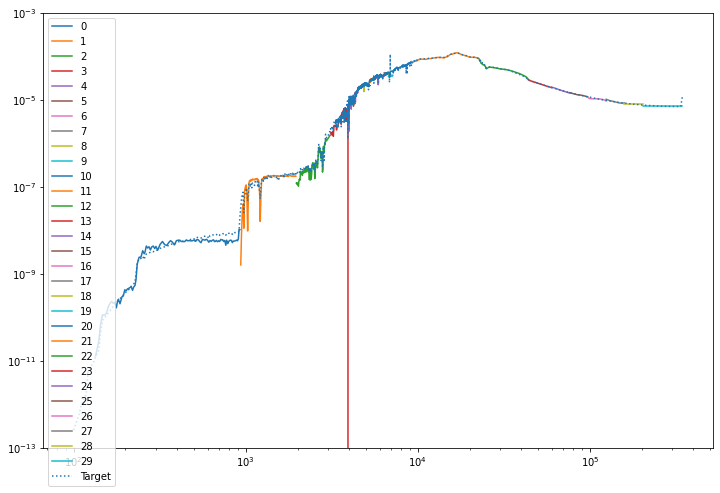

In [17]:
fig = plt.figure(figsize = (12, 8))
for i in range(len(all_norm_specs)):
    plt.loglog(ngc_4486_rest_wave[sections[i]:sections[i+1]], all_norm_specs[i][sections[i]:sections[i+1]], label = i)
    
plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label = "Target", ls = ":")
plt.ylim([1e-13,1e-3])
plt.legend()
plt.show()

Current Starting Position
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Optimizing Guess ***********


/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/apps/jupyterhub/1.1.0/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.11138097e-01 2.64911136e-02 1.69149866e-01 4.82364447e-01
 5.08489960e-02 9.98854866e-01 6.02140007e-02 2.83690979e-01
 6.48352023e-02 9.16059247e-03 9.16059247e-03 4.76928495e-02
 5.17983247e-02 6.05246140e-02 6.48352023e-02 1.24154006e+00
 2.63514235e-01 3.18834438e-01 2.20205125e-01 1.87135712e-01
 3.48695406e-01 7.55421484e-02 7.89005309e-02 1.24957447e-01
 6.66433702e-01 1.61013482e-01 2.64762109e-01 2.64762109e-01
 8.03650745e-04 8.03650745e-04]


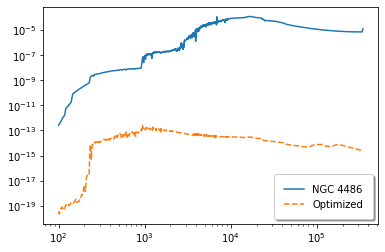

In [13]:
lb   = np.zeros(30)
ub   = np.full(30, 1e15)

starting_weight_array = np.zeros(30) + 0.01

print("Current Starting Position")
print(starting_weight_array)
print('Optimizing Guess ***********')

popt = optimize_guess(galactic_model_guess, starting_weight_array, lb, ub, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err, bins)
print(popt)

ngc_4486_opt_guess= galactic_model_guess(popt, ngc_4486_rest_wave, bins)

plt.loglog(ngc_4486_rest_wave, ngc_4486_flux, label='NGC 4486')
plt.loglog(ngc_4486_rest_wave, ngc_4486_opt_guess, ls='--', label='Optimized')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 10})
plt.show()

Steps Taken:  25000 Likelihood:  -497141.1738608737


<ipython-input-2-6b12f09e285f>:234: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  samples=sampler.chain[:, np.rint(no_of_steps/5).astype(np.int):, :].reshape((-1, ndim))#sampler.flatchain


Derived values are (weight array): 
 [11.41087306  2.15753053  2.12384472  2.33332516  7.92798044  1.05732687
  5.51772414  1.09014435  8.70203793  1.79805545  2.9296442   5.0621781
  4.61244219  4.95427419  4.94949607  0.78748713  1.50879422  0.36842933
  0.48513881  1.4816556   2.07647814  6.60882804  5.29156111  5.95051968
  0.72345058  8.41401381  2.02116123  2.79058841  0.55288291  0.18984546]


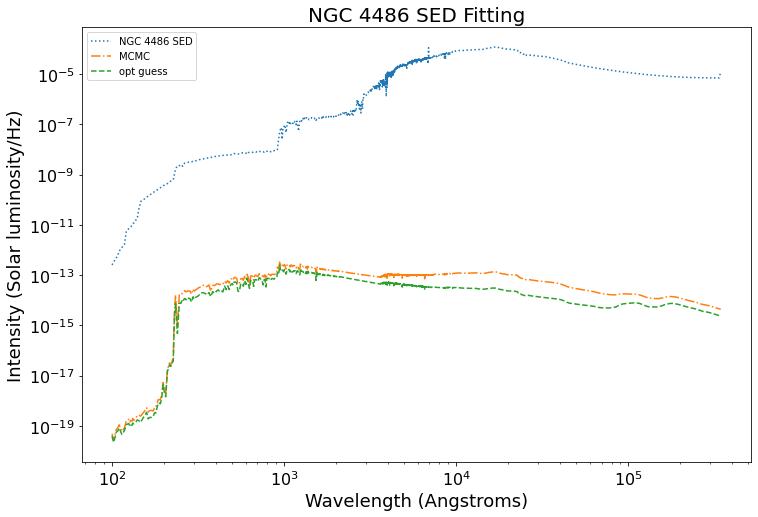

In [18]:
with Pool() as pool:
    perturbation = popt * 0.1
    no_of_Chain=500
    no_of_steps=5000

    text_label=[]

    for i in range(30):
        text_label.append('mass'+ str(i))

    lb   = np.zeros(30)
    ub   = np.full(30, 1e12)

    length_of_lb = len(lb)

    ndim, nwalkers = length_of_lb, no_of_Chain## Do the first MCMC operation.

    guesses = [popt + perturbation * np.random.randn(ndim) for i in range(nwalkers)]
    print("Starting emcee ***********")
    burntime = np.round(1000)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool = pool, moves = emcee.moves.StretchMove(a = 2), args=(lb, ub, galactic_model_guess, ngc_4486_rest_wave, ngc_4486_flux, ngc_4486_flux_err, bins))
    print("Start Burntime Calculations ***********")

    pos, prob, state = sampler.run_mcmc(guesses, burntime, progress = True)  #First Burning some steps
    sampler.reset()

    print("Done Burning Steps! Now starting the Final Calculations:")
    print("*****************")

    break_steps = 25000
    convergence_accuracy = 1e-4
    convergence_check = False
    
    sampler1, likelihood = initiate_walking(sampler, pos, no_of_steps, break_steps, convergence_accuracy, convergence_check, ngc_4486_flux, ngc_4486_flux_err, ngc_4486_rest_wave, galactic_model_guess, bins)

    title = "NGC 4486 SED Fitting"
    galaxy = "NGC 4486 SED"
    
    best_fit1, exp_weight_array1 = print_and_plot_results(sampler, ngc_4486_rest_wave, ngc_4486_flux, title, galaxy, galactic_model_guess, bins)
    
    plt.loglog(ngc_4486_rest_wave, best_fit1, label = "MCMC", ls = '-.')
    plt.loglog(ngc_4486_rest_wave,ngc_4486_opt_guess,label='opt guess', ls='--')
    plt.legend()
    plt.savefig("ngc_4486_log_30_test.jpg")
    plt.show()

In [20]:
print(likelihood)

[-510802.40809905756, -511007.00099727017, -511544.5316694259, -511355.59216568276, -511284.06546591135]


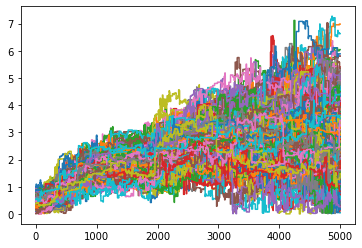

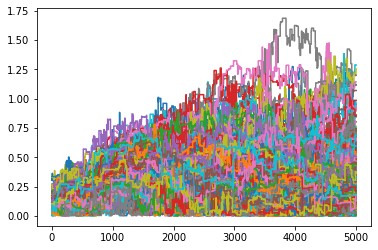

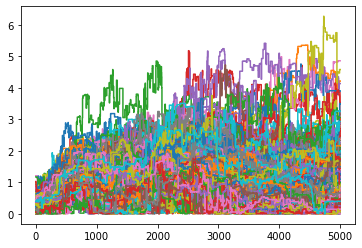

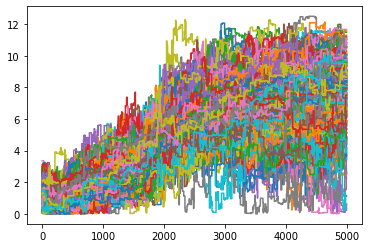

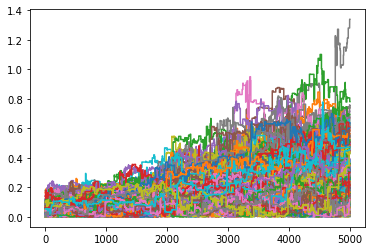

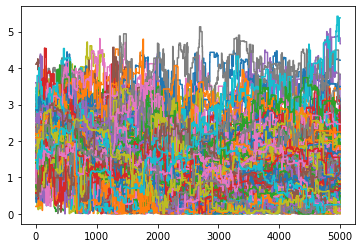

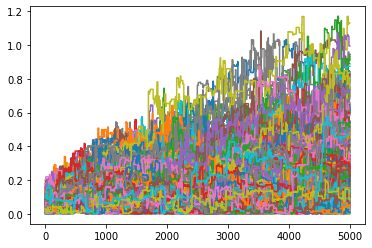

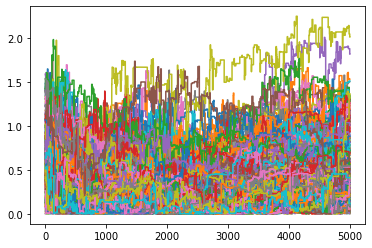

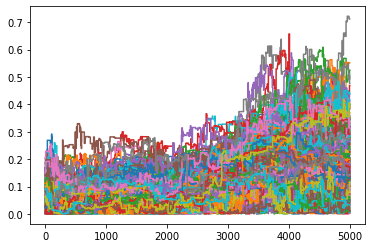

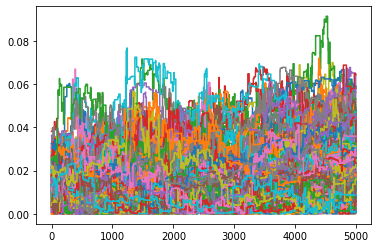

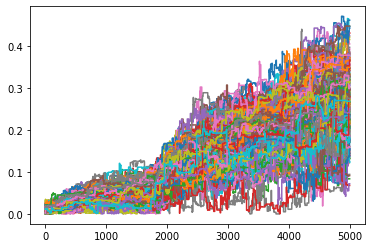

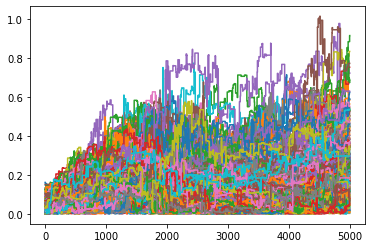

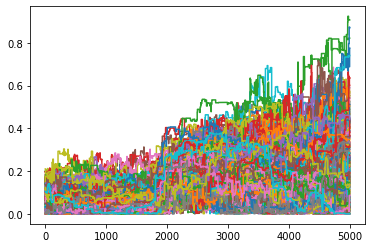

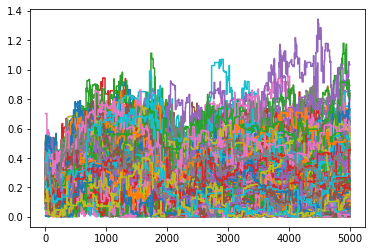

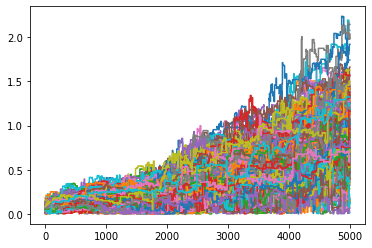

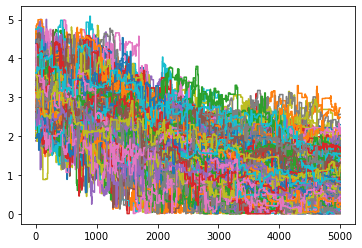

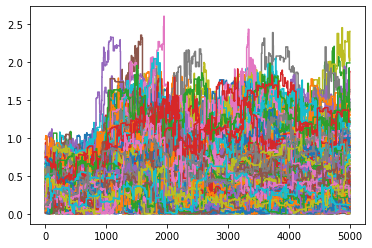

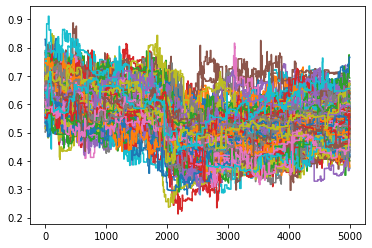

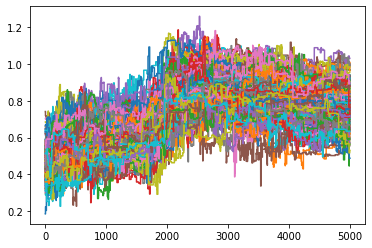

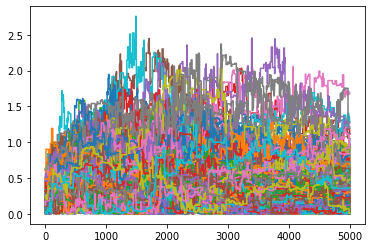

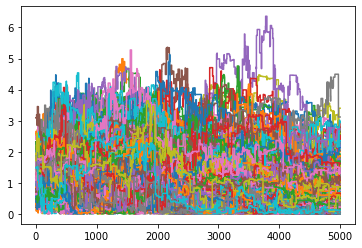

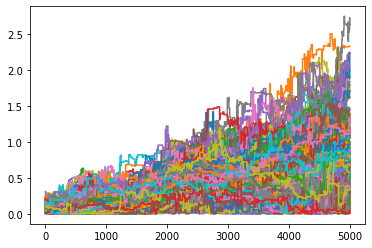

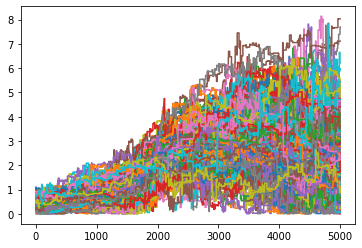

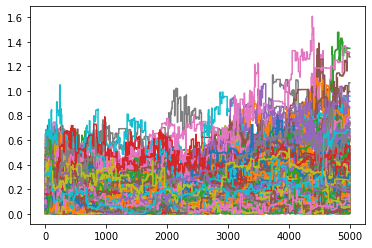

In [ ]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))
sampler_ = np.array( sampler.chain )

for this_dim in range(sampler_.shape[2]):   # number of parameters
    for walker_nr in range(sampler_.shape[0]):
        plt.step(range(sampler_.shape[1]), sampler_[walker_nr,:,this_dim])
    plt.show()

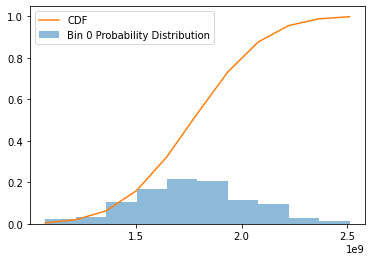

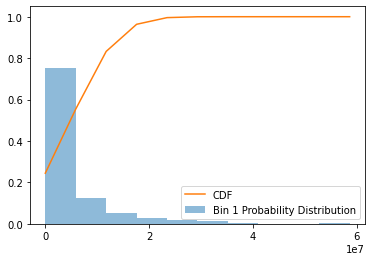

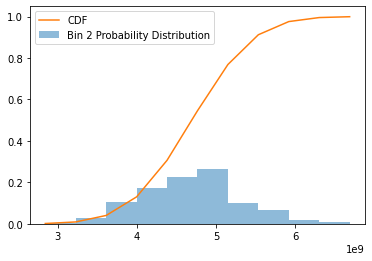

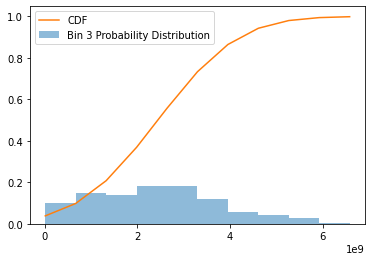

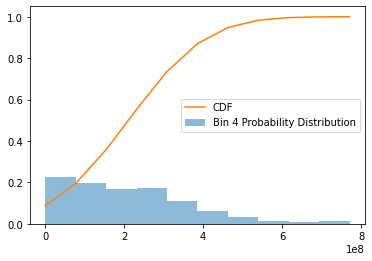

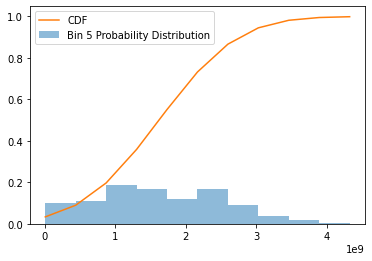

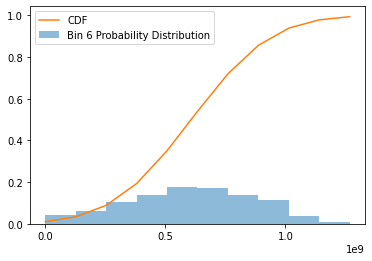

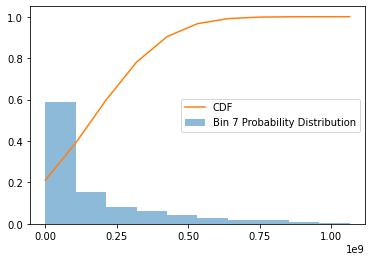

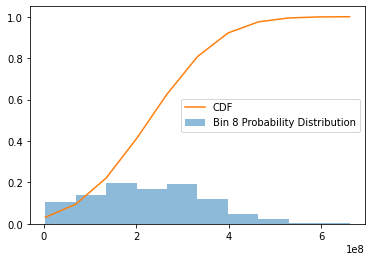

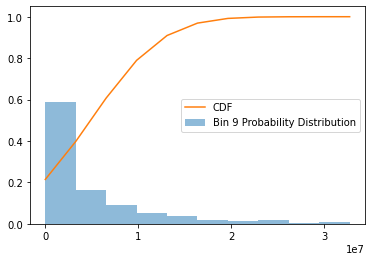

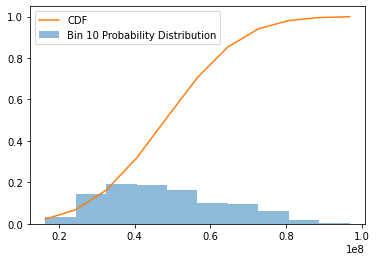

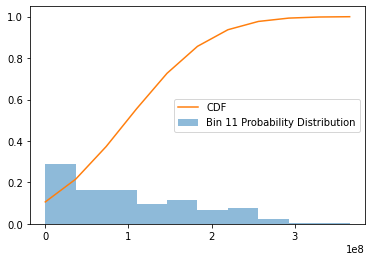

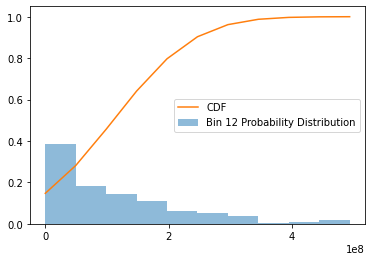

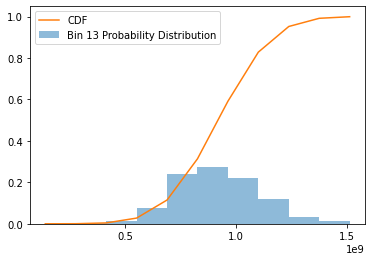

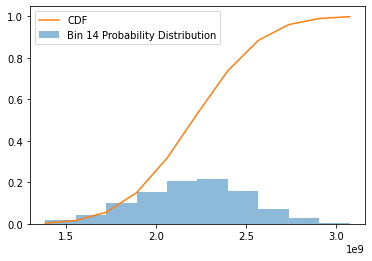

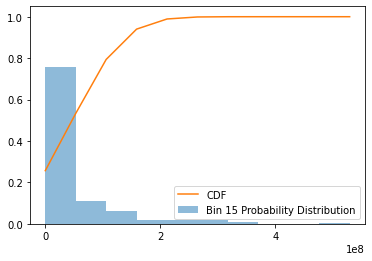

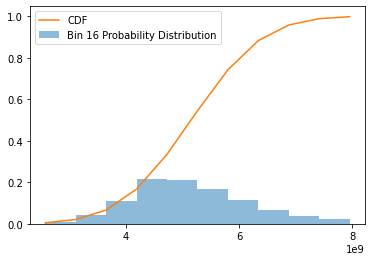

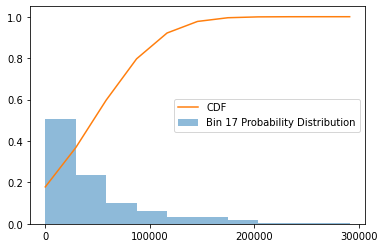

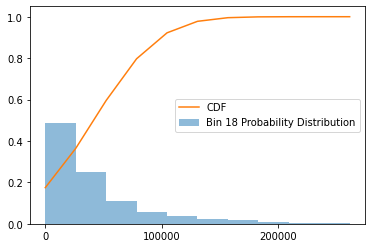

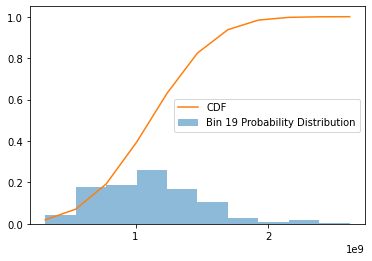

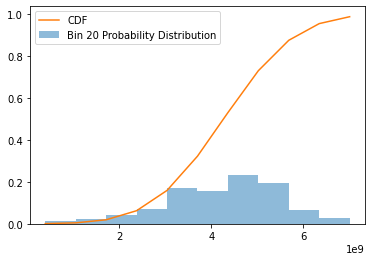

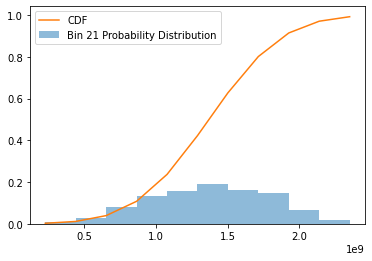

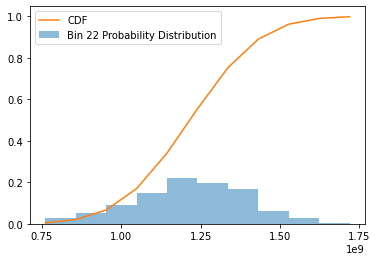

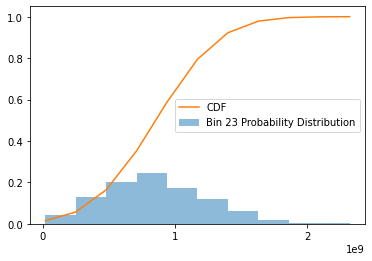

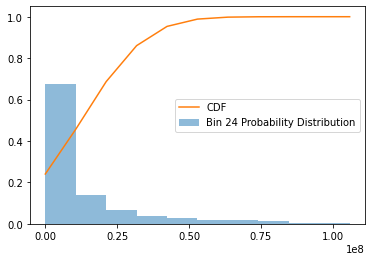

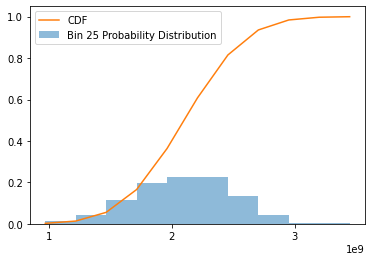

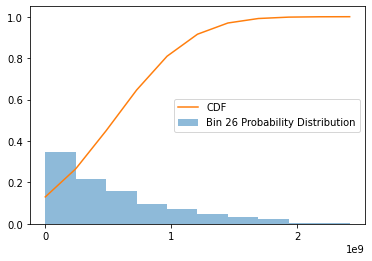

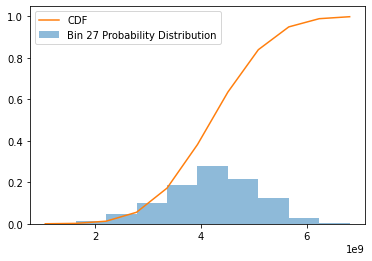

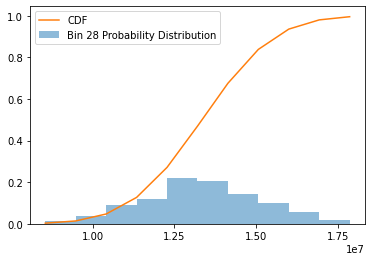

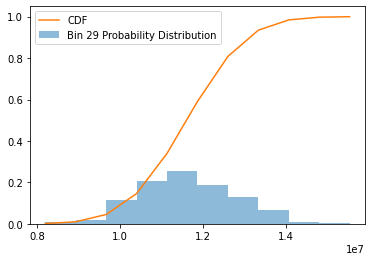

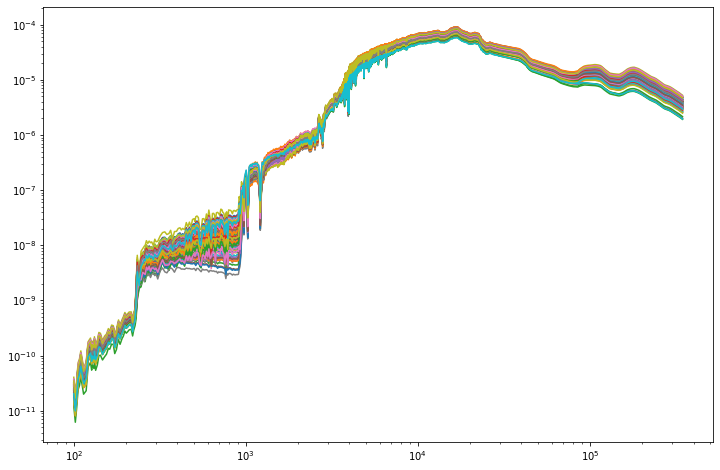

Derived Mass-to-light Ratio: 7.668e-01 +/- 2.367e-02
Input Mass-to-light Ratio: 6.300e+00
Standard Deviations Away: 233.813


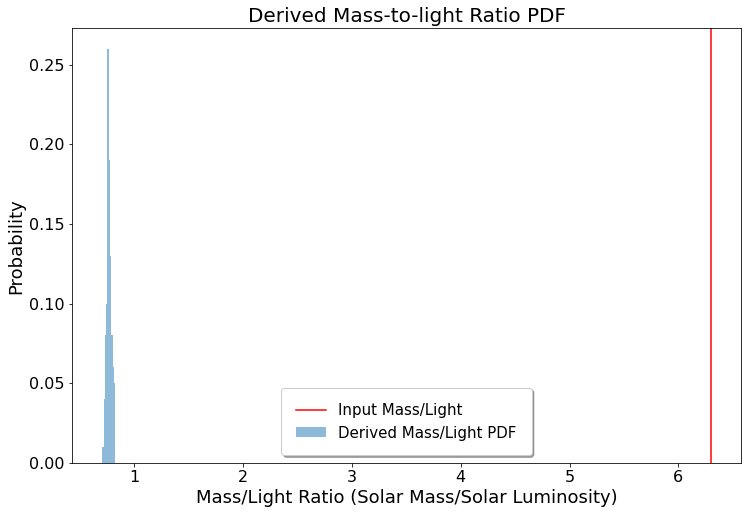

In [116]:
samples = 100
derived_mass_light, derived_mass_light_err = mass_light_pdf(sampler1, samples, ngc_4486_flux, ngc_4486_rest_wave, bins)
input_mass_light = 6.3

print("Derived Mass-to-light Ratio: {:.3e} +/- {:.3e}".format(derived_mass_light, derived_mass_light_err))
print("Input Mass-to-light Ratio: {:.3e}".format(input_mass_light))
print("Standard Deviations Away: {:.3f}".format(abs((derived_mass_light - input_mass_light)/(derived_mass_light_err))))
plt.axvline(x = input_mass_light, color = 'red', label = "Input Mass/Light")
plt.title('Derived Mass-to-light Ratio PDF', fontsize = 20)
plt.ylabel('Probability', fontsize = 18) # Labeling the x-axis
plt.xlabel('Mass/Light Ratio (Solar Mass/Solar Luminosity)', fontsize = 18) # Labeling the y-axis
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 15})  

plt.savefig("mass_light_pdf_new.jpg")    
plt.show()